# 7. Integration of Particle Orbits

As explained in the lecture, the integration of particle paths is on the one hand a non-trivial issue, in that one must be careful when choosing the method of integration, so particles don't lose or gain energy for purely numerical reasons.  On the other hand there does exist a simple and robust method; the kick-drift-kick (KDK) method, which is good enough for most practical purposes, except maybe longterm integration of planetary orbits.

### Overview
The purpose of this exercise is to give you a feeling for how many steps per orbit are needed to obtain a reasonable precision, and what kinds of errors that are avoided by using an energy conserving, "symplectic" (cf. Section 3.6 in the book) method.

### Setup
This notebook initialises `n` particles in the central potential of a star. _Keplerian_ units of mass = 1 solar mass, length = 1 au, and time = 1 yr are chosen such that GM = $4\pi^2$ for a 1 solar mass star. The particle orbits have radii `rad` with some normal distributed distribution with std dev `dispersion`. You will add to this an `eccentricity` (0 for circular, 1 for direct infall) with a normal distributed spread `edispersion` centered on ``e=0``. Since normal distributed variables can have arbitrarily large positive and negative values around the mean we limit the radial distribution to the interval `[rmin, rmax]`and the eccentricity to be below `emax`.

### The Kepler problem
The Kepler problem is a simplified two-body problem, where one of the bodies is a mass-less test particle. The motion is characterised by the two constants of motion. The specific (per mass) energy is:

\begin{equation}
E = {1 \over 2} v^2 - {GM \over r}
\end{equation}
and the specific (per mass) angular momentum is
\begin{equation}
L = r \times v
\end{equation}
The acceleration of the test particle is given from Newton's law of gravitation

\begin{equation}
\mathbf{a} = - \frac{GM}{r^2} \frac{\mathbf{r}}{r}
\end{equation}
For the special case of circular motion we have
\begin{equation}
v_\textrm{circle} = v_\textrm{Kepler} = \sqrt{\frac{GM}{r}}
\end{equation}
and the specific energy is $E_\textrm{circle} = - {1 \over 2} {GM \over r}$.

In the general case the orbit is an ellipse. The eccentricity of the ellipse can be caluculated from the specific energy and angular momentum as
\begin{equation}
e = \sqrt{1 + \frac{2 E L^2}{(GM)^2}}
\end{equation}
the orbit period $P$ and the semi-major axis $a$ are related to the specific energy as

\begin{align}
E  & = - {1 \over 2} {GM \over a} \\
P^2 & = \frac{4\pi^2}{GM} a^3
\end{align}

If the specific energy is positive, the particle is unbound.

These few key equations a enough to setup a simple Kepler problem with a given eccentricity and radius as done below. You can read more about the two-body problem in chapter 3.3 of the book.

### Preparations:
1. Review what the issues are, by reading Chapter 3 and/or the slide deck. Apart from secular (slow and systematic) changes in total energy, there are also other types of errors.  Paths that should be exactly elliptic can have nutation, for example, where the aphelion / perihelion positions rotate a small amount for each orbit. Such a path is typically also associated with a variation of total energy along the path so that, even though energy is conserved over full orbits, it is not conserved exactly during one orbit. Examples of that are in the slides, and you will also create your own below.
2. Review the setup below. The notebook contains a `Particles` class with basic particle data and related routines for computing radius, speed, energy, and orbital time.
3. The other class is called `Integration`. It contains a Kick-Drift-Kick integrator and a classical 3rd order Runge-Kutta (RK3) integrator. The KDK integrator has the optional `reflexive` option setting the timestep based on both the current and the future value of the timestep, to make the integration routine symmetric in time. It also has a simple Courant condition that is based on taking `norbit` steps per orbital time.
4. _Take your time_ to review the comments in the `__init__` procedure for each `class`. If you do not understand what the purpose of an option is, please ask.
5. Below the two class definitions is a small example of how to use the setup. With a low number of particles, the time, timestep (dt), position, and total energy of each particle is stored as a function of time, and a few statistics and orbital plots are made. This will help you understand the behaviour of the integrator with different sets of options.

In [1]:
import numpy as np                      # Import numpy and matplotlib.pyplot
import matplotlib.pyplot as plt
from time import time                   # Import time procedure for timing measurement
np.set_printoptions(linewidth=120)      # Expand the nr of columns used for printing
np.seterr(invalid='raise');             # Fail the code if any exception is raised 

In [2]:
class Particles():
    def __init__(self, n=50, rad=1., rmin=0.4, rmax=4., dispersion=0.1, \
                 edispersion=0.1, emax=0.95, starmass=1., seed=1234):
        self.n = n                          # number of particles
        self.rad = rad                      # radius [in AU] at which particles are inserted
        self.rmin = rmin                    # minimum and maximum initial radius
        self.rmax = rmax
        self.dispersion = dispersion        # dispersion [in AU] around radius
        self.edispersion = edispersion      # dispersion in eccentricity
        self.emax = emax                    # maximum eccentricity
        self.starmass = starmass            # stellar mass [solar masses]

        # Assume units where [M] = solar mass, [l]=AU, [t]=year.
        # Then the (unit-less) Kepler's law hold true and GM = 4 pi^2 for Sun.
        self.GM = 4. * np.pi**2 * self.starmass
        
        # Setup particles
        self.r = np.zeros((3,n))            # position
        self.v = np.zeros((3,n))            # momentum
        self.initialize(seed)
        
    def initialize(self,seed):
        """ Initialize random particles uniformly in angle with a dispersion
            in radius and eccentricity. Place all particles at aphelion.
        """
        np.random.seed(seed)
        
        # Radius equal initially to apastron (normal distributed)
        self.rm = np.random.normal(loc=self.rad, scale=self.dispersion, size=self.n) # dispersion is normal distributed
        self.rm = np.clip(self.rm,self.rmin,self.rmax)   # limit semi-major axis inside rmin and rmax

        # Eccentricity (normal distributed)
        # self.e = np.zeros(self.n) # circular orbit
        self.e = np.random.normal(loc=0., scale=self.edispersion, size=self.n)
        self.e = np.abs(np.clip(self.e,-self.emax,self.emax))            # limit eccentricity to be between 0 and emax

        # Phase compared to coordinate (self.rm,0) (uniform distributed)
        angle = np.random.uniform(low=0., high=2.0*np.pi, size=self.n)
        
        # position
        self.r[0] = self.rm*np.cos(angle)
        self.r[1] = self.rm*np.sin(angle)


        # velocity
        a = self.rm/(1 + self.e)
        self.vm = np.sqrt(self.GM*(2/self.rm - 1/a))              # Kepler speed

        # angle of velocity vector
        self.v[0] = -self.vm*np.sin(angle)
        self.v[1] = +self.vm*np.cos(angle) 
    
    def radius(self):
        """ Compute the scalar radii from the vector positions """
        self.rm = np.sqrt(np.sum(self.r**2,0))        

    def speed(self):
        """ Compute the scalar speeds from the vector velocity components """
        self.vm = np.sqrt(np.sum(self.v**2,0))
        
    def energy(self):
        """ Compute specific energy for particles """
        self.radius()
        self.speed()
        self.E = 0.5*self.vm**2 - self.GM / self.rm
        
    def Porbit(self):
        """ compute orbit time for particles """
        self.energy()
        a = - 0.5 * self.GM / self.E                          # semi-major axis
        a[np.where(a < 0.)] = a.max()                         # let a be largest possible for negative a,
                                                              # since those are unbound orbits
        return 2. * np.pi * a * np.sqrt(a) / np.sqrt(self.GM) # Period of orbit

In [3]:
class Integration():
    def __init__(self, p, Integrator='kdk', Courant='acceleration', \
                          norbit=100, reflexive=0):
        """ Setup integrator. p is a particle class with particle data """
        self.norbit = norbit               # dt control: nr of steps for a single orbit 
        self.Cdt = 2.*np.pi / norbit       # corresponding criteria for acceleration dt CFL condition

        # if self.reflexive>0 then use "reflexive" nr of trial steps to determine a time-symmetric dt for adaptive timestep
        self.reflexive  = reflexive
        
        self.nstep = 0                     # iteration step
        self.time = np.zeros(p.n)          # time
        self.dt = np.zeros(p.n)            # dt
        self.GM = p.GM                     # Transfer granvitational mass

        # choose integration method
        if Integrator=='kdk':
            self.Int = self.kdk
        if Integrator=='rk3':
            self.Int = self.rk3
        
        # choose Courant condition method
        if Courant=='orbit':
            self.courant = self.courant_orbit
        if Courant=='acceleration':
            self.courant = self.courant_acceleration
        
    def acceleration(self,r):
        """ Compute the gravitational acceleration at positions r """
        rm = np.sqrt(np.sum(r*r,0))
        if not np.any(rm < 1e-10):
            return -r*self.GM/(rm*rm*rm)
        return np.zeros(r.shape)
        
    def kick(self,p):
        """ Update the velocity with half a time step """
        p.v = p.v + (0.5*self.dt)*self.acceleration(p.r)

    def drift(self,p):
        """ Advance the positions with a time step """
        p.r = p.r + self.dt*p.v

    def kdk(self,p):
        """ Take a single Kick-Drift-Drift timestep """
        # if reflexive dt condition used, store old particle positions, velocities, and dts
        # remember to use "np.copy" to take a real copy of the variables.
        if self.reflexive > 0:
            olddt = np.copy(self.dt)
            oldr = np.copy(p.r)
            oldv = np.copy(p.v)


        self.kick(p)
        self.drift(p)
        self.kick(p)
        
        # if reflexive dt condition used, recompute dt, and
        # use averaged dt to redo the KDK step "self.reflexive" times
        # from stored positions and velocities
        if self.reflexive > 0:
            # make n more iteration for completeness
            for _ in range(self.reflexive):
                self.courant(p)
                self.dt = 0.5*(self.dt + olddt)

                p.r = np.copy(oldr)
                p.v = np.copy(oldv)

                self.kick(p)
                self.drift(p)
                self.kick(p)


    def rk3(self,p):
        """ Take a single 3rd order Runge-Kutta timestep. See e.g.
            http://www.mymathlib.com/diffeq/runge-kutta/runge_kutta_v1_3.html
            for algorithm """
        dr1 = self.dt * p.v
        dv1 = self.dt * self.acceleration(p.r)
        
        dr2 = self.dt * (p.v + 0.5 * dv1)
        dv2 = self.dt * self.acceleration(p.r + 0.5 * dr1)
        
        dr3 = self.dt * (p.v - dv1 + 2.*dv2)
        dv3 = self.dt * self.acceleration(p.r - dr1 + 2.*dr2)
        
        p.r += (dr1 + 4.*dr2 + dr3) / 6.
        p.v += (dv1 + 4.*dv2 + dv3) / 6.
        
    def courant_orbit(self,p):
        """ Determine dt such that norbit steps are taken to complete an orbit """
        P = p.Porbit()                       # Compute orbit time
        # See Porbit function: Unbound particles are set to have an orbit with the largest bound particle P / dt
        self.dt = P / self.norbit            # update dt
            
    def courant_acceleration(self,p):
        """ Determine dt based on acceleration and velocity """
        acc = np.sqrt(np.sum(self.acceleration(p.r)**2,0))
        p.speed()
        self.dt[:] = self.Cdt * p.vm / acc
        
    def step(self,p):
        """ Take a single timestep """
        self.Int(p)             # The integrator is selected with the "Integrator" option at init
        self.time += self.dt
        self.nstep += 1

In [90]:
# Setup particle distribution
def run_n(n = 10, reflexive = 0, norbit = 100, solver = "kdk", store_orbits_and_plot = False, verbose = False, seed = 1234):
    p=Particles(n=n,rad=1.,dispersion=0.2,edispersion=0.7, seed=seed, emax = 0.9)

    # Print some statistics
    p.energy(); p.radius(); p.speed()

    if verbose:
        print("Energy min, aver, max, std : {:.1f} {:.1f} {:.1f} {:.1f}".format(p.E.min(),p.E.mean(),p.E.max(),p.E.std()))
        print("Radius min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.rm.min(),p.rm.mean(),p.rm.max(),p.rm.std()))
        print("Speed  min, aver, max, std : {:.2f} {:.2f} {:.2f} {:.2f}".format(p.vm.min(),p.vm.mean(),p.vm.max(),p.vm.std()))


    # Setup integrator
    I = Integration(p,Integrator=solver,Courant='acceleration', \
                    norbit=norbit,reflexive=reflexive)

    # if use_constant_dt is set to True only calculate dt once. Should not be used with self.reflexive > 0!
    # If you set it to True you will see how KDK becomes symplectic because of the constant timestep.
    # use_constant_dt = True should not be used in the tasks below.
    use_constant_dt = False

    # Make lists to store data for plotting and analysis
    # Important to use np.copy, because otherwise just a pointer to data is made
    r = []; r.append(np.copy(p.r))                       # store position
    v = []; v.append(np.copy(p.v))                       # store velocity
    energy = []; p.energy(); energy.append(np.copy(p.E)) # store energy
    ptime = [np.copy(I.time)]                            # store time
    dt = [np.copy(I.dt)]                                 # store dt

    # Set timestep at start of integration!
    if use_constant_dt:
        I.courant(p)


    orb = p.Porbit() # Period of orbit for all particles
    # Integrate at least 1 orbit for all particles, but for maximum "use" seconds
    # Notice that each particle integrates with its own timestep.
    tend = 4*np.max(p.Porbit())  # Set tend to max period of orbit for any particle
    used = 0.0     # Time used in seconds
    use = 10.      # Max time used for integration of orbits in seconds
    while (used < use and I.time.min() < tend):
        start = time()
        if not use_constant_dt:
            I.courant(p) # Set timestep at start of integration step
        I.step(p)
        used += time()-start
        
        # store energy, time, and dt
        p.energy(); energy.append(np.copy(p.E))
        ptime.append(np.copy(I.time))
        dt.append(np.copy(I.dt))
        
        # store orbit
        if store_orbits_and_plot:
            r.append(np.copy(p.r))
            v.append(np.copy(p.v))

    # Performance timining
    if verbose:
        print('{:.1f} nanosec/particle-step'.format(used*1e9/p.n/I.nstep))
        print('Number of particles={} and integration steps={}: '.format(p.n,I.nstep))
        print('Min time={:.5} and end time={:.5}: '.format(I.time.min(), tend))

    # Transpose arrays to make it easier to plot and analyse afterwards
    energy = np.array(energy).transpose(1,0)
    ptime = np.array(ptime).transpose(1,0)
    dt = np.array(dt).transpose(1,0)
    if store_orbits_and_plot:
        r = np.array(r).transpose(2,1,0)
        v = np.array(v).transpose(2,1,0)

    # Make figure with orbits of particles    
    if store_orbits_and_plot:
        plt.figure(figsize=(11,8))
        for i in range(r.shape[0]):
            plt.plot(r[i,0],r[i,1],linewidth=1,label=i)
        plt.plot([0],[0],marker='*')
        plt.legend(ncol=2)
        plt.axis('scaled')
        plt.show()

    return energy, ptime, dt, r, v, orb

energy, ptime, dt, r, v, orbit = run_n(50, store_orbits_and_plot = True, norbit=33, reflexive=0)



C:\Users\jakob\AppData\Local\Temp\ipykernel_22768\2520994119.py:32: RuntimeWarning: overflow encountered in multiply
  return -r*self.GM/(rm*rm*rm)
C:\Users\jakob\AppData\Local\Temp\ipykernel_22768\2520994119.py:100: RuntimeWarning: divide by zero encountered in divide
  self.dt[:] = self.Cdt * p.vm / acc


FloatingPointError: invalid value encountered in multiply

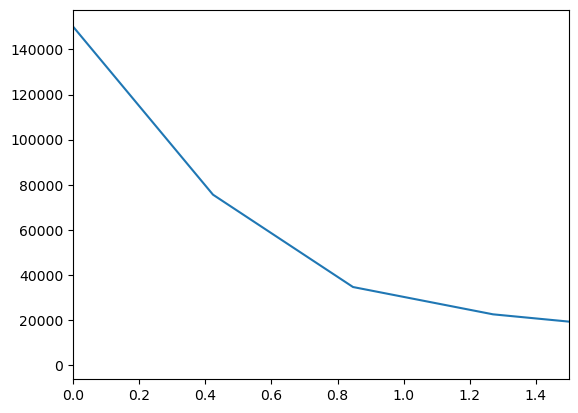

In [58]:
i_particle = 1
x = (energy[i_particle] / energy[i_particle,0]-1.)*100.
t = ptime[i_particle]
acf = np.correlate(x, x, 'full')[-len(x):]
pdg = np.fft.rfft(acf)
freqs = np.fft.rfftfreq(len(x), t[1]-t[0])

plt.plot(freqs, abs(pdg))

plt.xlim(0.0, 1.5)
plt.show()


Text(0, 0.5, 'Relative change in energy (%)')

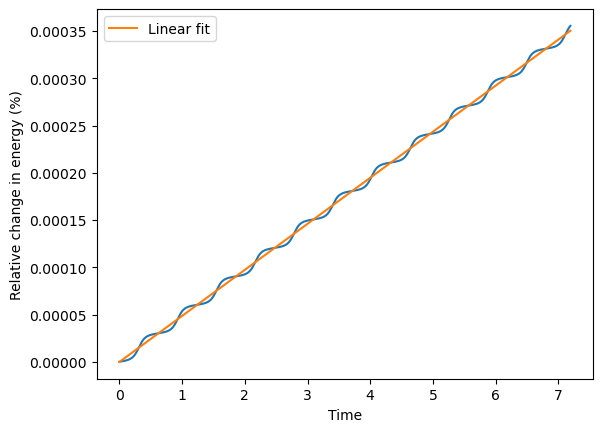

In [70]:
i_particle=7  # select particle track to plot energy for. Uses labels above.
y = (energy[i_particle] / energy[i_particle,0]-1.)*100.
plt.plot(ptime[i_particle],y)

# make a linear fit to the energy change
t = ptime[i_particle]
p = np.polyfit(t,y,1)
plt.plot(t,p[0]*t+p[1],label='Linear fit')
plt.legend()


plt.xlabel('Time')
plt.ylabel('Relative change in energy (%)')

In [ ]:
acf = np.correlate(x, x, 'full')[-len(x):]

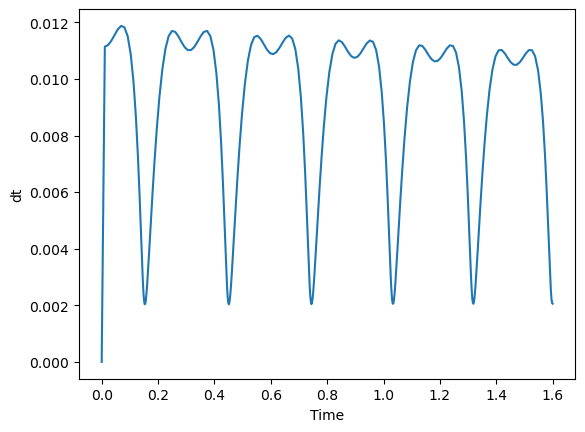

In [44]:
# Investigate change in dt at time of "kick"
i_particle=1  # select particle track to plot energy for 
# w = np.where(np.abs(ptime[i_particle]-0.35) < 0.3)
plt.plot(ptime[i_particle], dt[i_particle].squeeze())
orb = ptime[i_particle]%orbit[i_particle]
plt.plot(ptime[i_particle][1:], ((orb[:-1] - orb[1:]) > 0)/50)

# make a linear fit 


plt.xlabel('Time')
plt.ylabel('dt');

Notice that in the time integration routine above the call to the courant condition is inside the time loop. Set ``use_constant_dt=True`` to only compute the Courant condition once in the begining and get constant time-stepping.

#### __Task 1: Extend the initial condition to include eccentric orbits__ (20p)
In the current setup all orbits are circular. This is not much fun. Circular orbits in a central potential are trivial to integrate. Therefore, extend the ``initialize`` such that it creates eccentric orbits using the two variables ``edispersion`` and ``emax`` in the particle class to make normal distribution for the eccenticity of individual particle orbits. You can make use that a negative eccentricity is equal to a positive one, so the normal distribution is always centered at ``e=0``.

#### __Task 2: Make the KDK have a time symmetrized dt__ (20p)
As discussed in the lecture (see also http://adsabs.harvard.edu/abs/1995ApJ...443L..93H) a symplectic integrator with a variable timestep is not symplectic anymore. The simplest reason is that it is not time reversible, but the underlying Hamiltonian (e.g. the physical system) is. To improve on this, it has been suggested that if we instead define $\Delta t$ to be the average of $\Delta t$ at the start and end of the integration step
\begin{equation}
\Delta t = [ \Delta t(t_\textrm{old}) + \Delta t(t_\textrm{new}) ] / 2
\end{equation}
then the solution will be time-symmetric. One way to do this is after the KDK step to
recompute $\Delta t$ as $\Delta t(t_\textrm{new-1})$, construct a new $\Delta t$ as the average and then redo the KDK step with the new timestep. If needed, this can be iterated. In the above article they have shown excellent results. In this task you will implement this, so-called, reflexive timestep. In the `Integration` class there already is defined a variable `self.reflexive`. Test if it is larger than zero inside the `kdk` routine, and if it is the case recompute `self.dt` as the average of the old value of `self.dt` (remember to store it before recomputing) and the new value (`self.reflexive=1`). If `self.reflexive>1` the computation of an average $\Delta t$ is itereated several times to reach an even more time reversible integration path.

Choose a one of the particles. How does the secular error in the energy per orbit change as when using reflexive=0 and norbit=100 compared to (reflexive,norbit)=(1,50) and (2,33)? E.g. with a constant number of KDK evaluations. 

#### __Task 3: Investigate fluctuations in energy__ (20p)
Use the setup to integrate 50 particles forward in time, and investigate how changes in particle energy depend on the `norbit` parameter, which controls the timestep. Note that with the `reflexive` option active (set to a small value of e.g. 1), fewer updates is needed to reach the same accuracy. Take note of the values printed in the three cases (KDK with `reflexive=0`, KDK with `reflexive=1` and RK3).

Think about how to measure the secular error in the energy as a function of orbits (e.g. time). Once you have decided on how to measure the error, make a log-log plot showing the error in the energy normalised to the initial orbital energy, as a function of `norbit`=[100,200,400,1000] (decrease `norbit` with a factor of 2 for reflexive=1 to reflect the extra cost of each integration step). _It may be an advantage to turn off the storage and plotting of orbits to speed up the integration by setting_ ``store_orbits_and_plot = False``. Comment on the result.

# __Absalon turn-in:__

Please add the updated code below this line together with plots and your supporting discussion of the results. Upload the notebook and a pdf copy of the notebook.

After having debated for a long time about a good measure for the secular energy change, we came up with the following: Simulating multiple orbits for all planets and then fitting the relative energy change, to find a quantitative estimate of the change over time.

Below six examples can be seen:

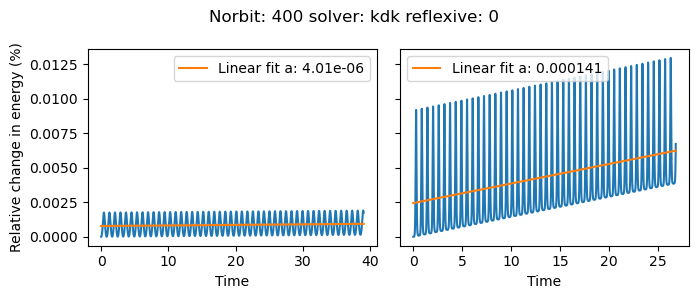

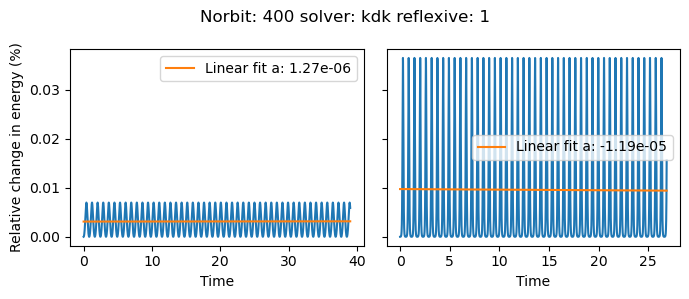

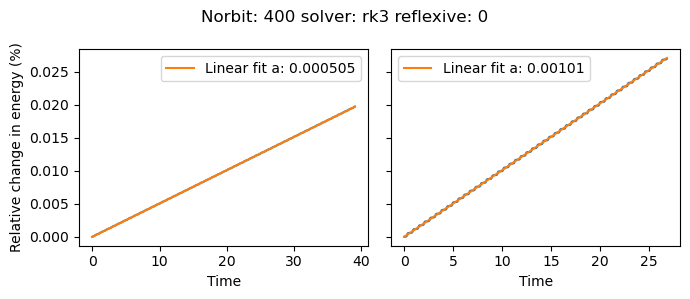

In [100]:
norbits = [100, 200, 400, 1000]
solver_refs = [("kdk", 0), ("kdk", 1), ("rk3",0)]
kkk = 0
energies = np.empty((len(norbits),len(solver_refs)))
for i, norbit in enumerate(norbits):
    for ii, sol_ref in enumerate(solver_refs):
        kkk += 1
        sol, ref = sol_ref
        energy, ptime, dt, r, v, orb = run_n(50, reflexive= ref, norbit = norbit / (2 if ref == 1 else 1), solver = sol, store_orbits_and_plot = False)
        # energy, ptime, dt, r, v = run_n(50, reflexive= 0, norbit = 20, solver = "kdk", store_orbits_and_plot = True)

        start_energies = energy[:,0]

        # e = (np.abs((start_energies[:,None] - energy)/start_energies[:,None])).max()

        # make a linear fit of the energies


        engis = [(energy[i_particle] / energy[i_particle,0]-1.)*100. for i_particle in range(energy.shape[0])]


        # p = np.polyfit(t,y,1)
        fits  = [np.polyfit(t,y,1)  for (t,y) in zip(ptime, engis)]
        es = [f[0] for f in fits]

        if i == 2:
            fig, axs = plt.subplots(1,2, figsize = (7,3), sharey=1)
            num = 3
            axs[0].plot(ptime[num], engis[num])
            axs[0].plot(ptime[num], fits[num][0]*ptime[num] + fits[num][1], label = f"Linear fit a: {fits[num][0]:.3}")
            num = 30
            axs[1].plot(ptime[num], engis[num])
            axs[1].plot(ptime[num], fits[num][0]*ptime[num] + fits[num][1], label = f"Linear fit a: {fits[num][0]:.3}")
            axs[0].legend()
            axs[1].legend()
            fig.suptitle("Norbit: " + str(norbit) + " solver: " + sol + " reflexive: " + str(ref))

            axs[0].set_xlabel("Time")
            axs[1].set_xlabel("Time")
            axs[0].set_ylabel("Relative change in energy (%)")
            fig.tight_layout()
            plt.show()

        energies[i,ii] = np.mean(np.abs(es))




As can be seen, it is pretty convining that the fittet gradient of the linear function is a pretty good measure for long term (/secular) energy change.

Meaning the absolute value of these, we can generate the following plot:

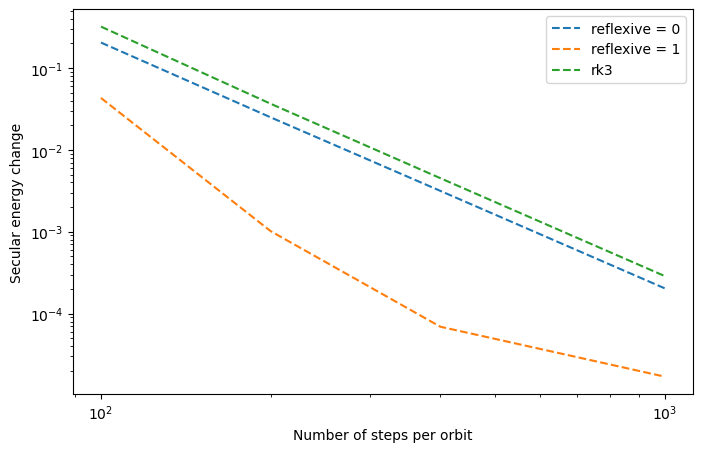

In [103]:
plt.figure(figsize=(8,5))
plt.loglog(norbits, energies[:,0],'--', label = "reflexive = 0")
plt.loglog(norbits, energies[:,1],'--', label = "reflexive = 1")
plt.loglog(norbits, energies[:,2],'--', label = "rk3")
plt.xlabel("Number of steps per orbit")
plt.ylabel("Secular energy change")
plt.legend()
plt.show()


And we get exactly what we expected! 

While KDK has worse energy conservation within each orbit, it does slightly better than RK3 on stability in the long run. But when even a single reflexive step is used, the symplecticity of the integrator improves the result significantly.